In [30]:
# Install Java, Spark, and Findspark
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:13 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64

In [31]:
# I have yelp 100k dataset loaded into my google drive
# this allows me to access that data from inside spark
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [32]:
# Start a SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("word2vec").getOrCreate()

In [33]:
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.ml.feature import Word2Vec
import string

schema = StructType([StructField("text", StringType(), True)])

In [34]:
# This URL is on my gdrive only! I loaded it there from a download from the internet
url = "/content/gdrive/MyDrive/covidvaccinedata_2021-03-13_v2_AGP_NOV03-07-2020.csv"
df = spark.read.schema(schema).csv(url, sep=",", header=False)

In [35]:
df.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------+
|text                                                                                                       |
+-----------------------------------------------------------------------------------------------------------+
|TEXT_CLEANED                                                                                               |
|Al Gore Didnt he say something about  oceans that is physically IMPOSSIBLE                                 |
|ClimateChange aka GlobalWarming "                                                                          |
|Belgian newspaper claims nvax has 400M dose covidvaccine deal with Europewhere did y get this from         |
|Covid Vaccine Trial A Nurses Experience                                                                    |
|covid vaccine immunization covidvaccine "                                                                  |
|Covid19 v

In [36]:
# punctuation removal due to relatively small datasize
def remove_punctuation(txt):
  return "".join(l if l not in string.punctuation else "" for l in txt)

In [37]:
from pyspark.sql.functions import col, udf

remove_punctuation_udf = udf(remove_punctuation, StringType())
remove_punctuation_udf

<function __main__.remove_punctuation>

In [38]:
df = df.withColumn("clean_text", remove_punctuation_udf(col("text")))
df.show()

+--------------------+--------------------+
|                text|          clean_text|
+--------------------+--------------------+
|        TEXT_CLEANED|         TEXTCLEANED|
|Al Gore Didnt he ...|Al Gore Didnt he ...|
|ClimateChange aka...|ClimateChange aka...|
|Belgian newspaper...|Belgian newspaper...|
|Covid Vaccine Tri...|Covid Vaccine Tri...|
|covid vaccine imm...|covid vaccine imm...|
|Covid19 vaccine c...|Covid19 vaccine c...|
|Presented by Dr A...|Presented by Dr A...|
|56 are in Phase I...|56 are in Phase I...|
|A list of who sho...|A list of who sho...|
|Im talking  some ...|Im talking  some ...|
|You know what I d...|You know what I d...|
| Yes  key thread was| Yes  key thread was|
|1 should GPs deli...|1 should GPs deli...|
|2 how can this be...|2 how can this be...|
|          Any ors Qs|          Any ors Qs|
|         We are al "|          We are al |
|     Yes I will w...|     Yes I will w...|
|In a few weeks af...|In a few weeks af...|
|       CovidVaccine |       Cov

In [42]:
# pandas dataframe to measure length
df_new = df.toPandas()
len(df_new)

666

In [43]:
from pyspark.sql.functions import length
length(df.text)

Column<b'length(text)'>

In [44]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.ml import Pipeline

# "Creating pipeline..."
tokenizer = Tokenizer(inputCol="clean_text", outputCol="token_text")
stopremove = StopWordsRemover(inputCol='token_text', outputCol='features')

pipeline = Pipeline(stages=[tokenizer, stopremove])

# "Training model..."
pipeline_stg = pipeline.fit(df)
final_df = pipeline_stg.transform(df)
final_df.show()

+--------------------+--------------------+--------------------+--------------------+
|                text|          clean_text|          token_text|            features|
+--------------------+--------------------+--------------------+--------------------+
|        TEXT_CLEANED|         TEXTCLEANED|       [textcleaned]|       [textcleaned]|
|Al Gore Didnt he ...|Al Gore Didnt he ...|[al, gore, didnt,...|[al, gore, didnt,...|
|ClimateChange aka...|ClimateChange aka...|[climatechange, a...|[climatechange, a...|
|Belgian newspaper...|Belgian newspaper...|[belgian, newspap...|[belgian, newspap...|
|Covid Vaccine Tri...|Covid Vaccine Tri...|[covid, vaccine, ...|[covid, vaccine, ...|
|covid vaccine imm...|covid vaccine imm...|[covid, vaccine, ...|[covid, vaccine, ...|
|Covid19 vaccine c...|Covid19 vaccine c...|[covid19, vaccine...|[covid19, vaccine...|
|Presented by Dr A...|Presented by Dr A...|[presented, by, d...|[presented, dr, a...|
|56 are in Phase I...|56 are in Phase I...|[56, are, i

In [60]:
# in class I had used vectorsize of 200 and max iterations of 2
word2vec = Word2Vec(
    vectorSize=200,
    seed=42,
    inputCol="features",
    outputCol="model"
).setMaxIter(3)
model = word2vec.fit(final_df)

In [61]:
model.getVectors().show(truncate=False)

+-----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [62]:
vecs = model.getVectors()

In [63]:
vecs.filter(vecs["word"] == "incident").show()

+----+------+
|word|vector|
+----+------+
+----+------+



In [64]:
# TEST WORDS HERE
model.findSynonymsArray("shot", 20)

[('trial', 0.97221839427948),
 ('oxford', 0.9700771570205688),
 ('early', 0.9667843580245972),
 ('february', 0.9650205373764038),
 ('2021', 0.9649608135223389),
 ('study', 0.9592773914337158),
 ('launched', 0.944092333316803),
 ('says', 0.9390848278999329),
 ('astrazeneca', 0.9361045956611633),
 ('coronavirus', 0.9279035925865173),
 ('chief', 0.927699089050293),
 ('icmr', 0.8994871377944946),
 ('covid„éº19', 0.8868749737739563),
 ('next', 0.8847770690917969),
 ('cidate', 0.8541718125343323),
 ('year', 0.8357106447219849),
 ('covaxin', 0.8305656313896179),
 ('chance', 0.8263535499572754),
 ('3', 0.8215896487236023),
 ('potential', 0.8063151240348816)]

In [65]:
w2v = model.transform(final_df)

In [66]:
w2v.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|          clean_text|          token_text|            features|               model|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|        TEXT_CLEANED|         TEXTCLEANED|       [textcleaned]|       [textcleaned]|[0.0,0.0,0.0,0.0,...|
|Al Gore Didnt he ...|Al Gore Didnt he ...|[al, gore, didnt,...|[al, gore, didnt,...|[0.00765810904300...|
|ClimateChange aka...|ClimateChange aka...|[climatechange, a...|[climatechange, a...|[0.0,0.0,0.0,0.0,...|
|Belgian newspaper...|Belgian newspaper...|[belgian, newspap...|[belgian, newspap...|[-0.0074231320230...|
|Covid Vaccine Tri...|Covid Vaccine Tri...|[covid, vaccine, ...|[covid, vaccine, ...|[-0.0650927245616...|
|covid vaccine imm...|covid vaccine imm...|[covid, vaccine, ...|[covid, vaccine, ...|[-0.0726693719625...|
|Covid19 vaccine c...|Covid19 vaccine

In [67]:
w2v_clustering = w2v.select(
    "text", "model"
).withColumnRenamed("model", "features")

In [68]:
w2v_clustering.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [69]:
from pyspark.ml.feature import PCA
from pyspark.mllib.linalg import Vectors

pca = PCA(k=10, inputCol="features", outputCol="pcaFeatures")
PCAmodel = pca.fit(w2v_clustering)
result = PCAmodel.transform(w2v_clustering)
result.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [70]:
result = result.select("text", "pcaFeatures")
w2v_clustering = result.withColumnRenamed("pcaFeatures", "features")
w2v_clustering.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                       |features                                                                                                                                                                                                                     |
+-----------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|TEX

In [75]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Trains a k-means model. < TRY NEW GROUP NUMBERS HERE 
kmeans = KMeans().setK(9).setSeed(1)
km_model = kmeans.fit(w2v_clustering)

In [76]:
# Make predictions
predictions = km_model.transform(w2v_clustering)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(distanceMeasure="cosine")

# TEST YOUR FIT
# silhouette score goes between -1, 1. 1 is better. Negative is bad
silhouette = evaluator.evaluate(predictions)
print("Silhouette with cosine distance = " + str(silhouette))

Silhouette with cosine distance = 0.26936648207037484


In [73]:
# AGP INSERT >> FIND BEST CLUSTER Size? ["Elbow Method"]
import numpy as np
import pandas as pd

# Calculate clusterSize and plot
clusterSize = np.zeros(15)

for k in range(2,15):
    # Trains a k-means model.
    kmeans = KMeans().setK(k).setSeed(1)
    km_model = kmeans.fit(w2v_clustering)
    predictions = km_model.transform(w2v_clustering)
    evaluator = ClusteringEvaluator(distanceMeasure="cosine")
    clusterSize[k] = evaluator.evaluate(predictions)

# Define the dataframe of cosines
df_clusterSize = pd.DataFrame(clusterSize[2:])
df_clusterSize.columns = ["cosine"]
new_col = [2,3,4,5,6,7,8,9,10,11,12,13,14]
df_clusterSize.insert(0, 'cluster', new_col)

df_clusterSize

,cluster,cosine
0,2,0.000000
1,3,0.000000
2,4,0.000000
3,5,0.024198
4,6,0.218370
5,7,0.237488
6,8,0.249138
7,9,0.269366
8,10,0.185044
9,11,0.207238


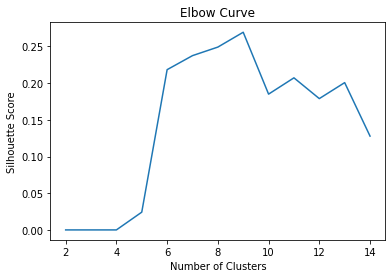

In [74]:
# PLOT the cosines

import pylab as pl
pl.plot(df_clusterSize.cluster, df_clusterSize.cosine)
pl.xlabel('Number of Clusters')
pl.ylabel('Silhouette Score')
pl.title('Elbow Curve')
pl.show()

In [77]:
predictions.show()

+--------------------+--------------------+----------+
|                text|            features|prediction|
+--------------------+--------------------+----------+
|        TEXT_CLEANED|[0.0,0.0,0.0,0.0,...|         7|
|Al Gore Didnt he ...|[-0.0599538410468...|         8|
|ClimateChange aka...|[0.0,0.0,0.0,0.0,...|         7|
|Belgian newspaper...|[0.05067667245965...|         8|
|Covid Vaccine Tri...|[0.25735706780703...|         2|
|covid vaccine imm...|[0.39020194973401...|         3|
|Covid19 vaccine c...|[0.24317832544220...|         4|
|Presented by Dr A...|[6.53984630036426...|         7|
|56 are in Phase I...|[0.04490243430432...|         8|
|A list of who sho...|[-0.0495259951342...|         0|
|Im talking  some ...|[-0.0776420937737...|         0|
|You know what I d...|[-0.0608359925809...|         0|
| Yes  key thread was|[-0.1448855019964...|         0|
|1 should GPs deli...|[0.12755208585296...|         8|
|2 how can this be...|[-5.6977906877236...|         8|
|         

In [ ]:
predictions.filter("prediction=6").show(50, truncate=False)

+---------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|text                                               |features                                                                                                                                                                                                           |prediction|
+---------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|AstraZeneca CovidVaccine QuickTake                 |[-0.5042872232435108,-0.4244550587161168,-0.09282570179091675,0.09685284144724195,0.04865785002721759,7.357510826703